<a href="https://colab.research.google.com/github/cathyxinchangli/ATMS-597-SP-2020/blob/sarah/Copy_of_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
"""Weekly Averaged Temperature for NYC"""
# This code is part of a class assignment for ATMS 597, Spring 2020,
# at the University of Illinois at Urbana Champaign.
# Use this code to display weekly average temperature in NYC from
# 01/01/2018 to 01/01/2019 in a climate stripes graph.

import requests
import pandas as pd
import datetime
from IPython import display # for updating the cell dynamically
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import pandas as pd

def make_request(endpoint, payload=None):
    """
    Make a request to a specific endpoint on the weather API
    passing headers and optional payload.
    
    Parameters:
        - endpoint: The endpoint of the API you want to 
                    make a GET request to.
        - payload: A dictionary of data to pass along 
                   with the request.
    
    Returns:
        Response object.
    ---
    S. Moline, 'Hands on Data Analysis with Pandas'
    https://github.com/stefmolin/Hands-On-Data-Analysis-with-Pandas/blob/master/ch_04/0-weather_data_collection.ipynb
    """
    return requests.get(
        f'https://www.ncdc.noaa.gov/cdo-web/api/v2/{endpoint}',
        headers={
            'token': 'HfZphTTGbXckpmEuqevAXQZFRCTEJgkJ' # obtained by X. Li, 2/4/2020
        },
        params=payload
    )

# Set date range
current = datetime.date(2018, 1, 1)
end = datetime.date(2019, 1, 1)

results = []
while current < end:
    # Update the cell with status information
    display.clear_output(wait=True)
    display.display(f'Gathering data for {str(current)}')
    
    response = make_request(
        'data', 
        {
            'datasetid' : 'GHCND', # Global Historical Climatology Network - Daily (GHCND) dataset
            'datatypeid' : ['TMAX','TMIN'],
            'locationid' : 'CITY:US360019', # NYC
            'stationid' : 'GHCND:USC00280907',
            'startdate' : current,
            'enddate' : current,
            'units' : 'metric',
            'limit' : 1000 # max allowed
        })

    if response.ok:
        # We extend the list instead of appending to avoid getting a nested list
        results.extend(response.json()['results'])

    # Update the current date to avoid an infinite loop
    current += datetime.timedelta(days=1)

def clean_up(datain,key):
    '''
    TBD
    credit S. Nesbitt
    '''
    datain[key][(datain[key] == 9999)] = None
    datain[key]= datain[key].astype('float')
    return datain

'Gathering data for 2018-12-31'

In [0]:
# Create a dataframe to store the results
# Contains date, TMAX, TMIN, station, and value
df = pd.DataFrame(results)

In [0]:
# Clean up data for missing values (as represented by '9999' according to 
# GHCND documentation: https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf)
df = clean_up(df, 'value')
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df.index = df['date']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
# Resample to be weekly average:
df2 = df.resample('W').mean() #'W': weekly frequency

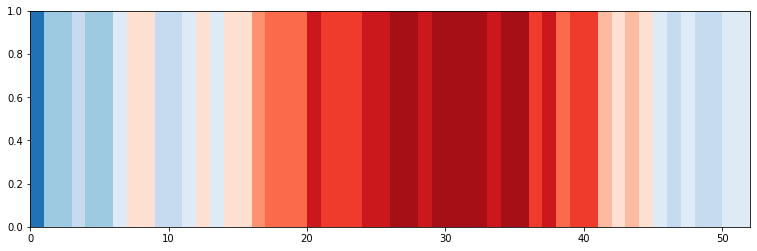

In [0]:
# Plotting
# copied from https://matplotlib.org/matplotblog/posts/warming-stripes/

# Time period
FIRST = datetime.date(2018, 1, 1)
LAST = datetime.date(2019, 1, 1)  # inclusive

# Reference period for the center of the color scale
FIRST_REFERENCE = datetime.date(2018, 3, 1)
LAST_REFERENCE = datetime.date(2018, 5, 1)

# Calculate anomaly
tavg = df2.loc[FIRST:LAST, 'value'].dropna() # average temperature
reference = tavg.loc[FIRST_REFERENCE:LAST_REFERENCE].mean()

LIM = tavg.quantile(q=0.95) # degrees

# The colors in this colormap come from http://colorbrewer2.org
# The 8 more saturated colors from the 9 blues / 9 reds
cmap = ListedColormap([
    '#08306b', '#08519c', '#2171b5', '#4292c6',
    '#6baed6', '#9ecae1', '#c6dbef', '#deebf7',
    '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a',
    '#ef3b2c', '#cb181d', '#a50f15', '#67000d',
])

fig = plt.figure(figsize=(10, 3))

####### NEED TO MODIFY ######
ax = fig.add_axes([0, 0, 1, 1])
ax.set_ylim(0,1)
# ax.set_axis_off() # if user chooses to overlay data on top of the strips, we need the axes.
#############################


# Add Climate Stripes
col = PatchCollection([Rectangle((y, 0), 1, 1) for y in range(52)])
col.set_array(tavg)
col.set_cmap(cmap)
col.set_clim(reference - LIM, reference + LIM)
ax.add_collection(col)
ax.set_xlim(0, 52)

###### NEED TO ADD ######
# line plot of data points
# tavg.plot(ax=ax, secondary_y=True)
#ax.set_xlim(FIRST, LAST + pd.Timedelta(days=1))
#########################


fig.savefig('warming-stripes.png')
plt.show()
